In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Object_Detection/object_detection_dataset.zip

Archive:  /content/drive/MyDrive/Object_Detection/object_detection_dataset.zip
   creating: object_detection_dataset/
  inflating: object_detection_dataset/1717.jpg  
  inflating: object_detection_dataset/22.jpg  
  inflating: object_detection_dataset/1801.jpg  
  inflating: object_detection_dataset/2617.jpg  
  inflating: object_detection_dataset/2629.jpg  
  inflating: object_detection_dataset/1113.jpg  
  inflating: object_detection_dataset/597.jpg  
  inflating: object_detection_dataset/1463.jpg  
  inflating: object_detection_dataset/1003.jpg  
  inflating: object_detection_dataset/1954.jpg  
  inflating: object_detection_dataset/937.jpg  
  inflating: object_detection_dataset/1723.jpg  
  inflating: object_detection_dataset/2348.jpg  
  inflating: object_detection_dataset/578.jpg  
  inflating: object_detection_dataset/2344.jpg  
  inflating: object_detection_dataset/2475.jpg  
  inflating: object_detection_dataset/901.jpg  
  inflating: object_detection_dataset/2289.jpg  
  infl

In [3]:
!pip install pycocotools numpy opencv-python tqdm tensorboard tensorboardX pyyaml webcolors

     |████████████████████████████████| 124 kB 5.0 MB/s 


In [4]:
cd /content/drive/MyDrive/Object_Detection/Yet-Another-EfficientDet-Pytorch

/content/drive/MyDrive/Object_Detection/Yet-Another-EfficientDet-Pytorch


In [5]:
import torch
from torch.utils.data import Dataset
import cv2
import matplotlib.pyplot as plt

In [6]:
# original author: signatrix
# adapted from https://github.com/signatrix/efficientdet/blob/master/train.py
# modified by Zylo117

import argparse
import datetime
import os
import traceback

import numpy as np
import torch
import yaml
from tensorboardX import SummaryWriter
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.autonotebook import tqdm

from backbone import EfficientDetBackbone
# from efficientdet.dataset import collater
from efficientdet.loss import FocalLoss
from utils.sync_batchnorm import patch_replication_callback
from utils.utils import replace_w_sync_bn, CustomDataParallel, get_last_weights, init_weights, boolean_string

In [7]:
from numpy import random

class Resize(object):
    def __init__(self, img_size=512):
        self.img_size = img_size

    def __call__(self, img):
        return cv2.resize(img, (self.img_size, self.img_size), interpolation=cv2.INTER_CUBIC)

class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image

class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image 

class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image 

class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
            image = np.clip(image, 0, 255)
        return image

class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image 

class Compose(object):
    

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img= t(img)
        return img

class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(lower=0.8, upper=1.2),
            ConvertColor(transform='HSV'),
            RandomSaturation(lower=0.8, upper=1.2),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast(lower=0.8, upper=1.2)
        ]
        self.rand_brightness = RandomBrightness()

    def __call__(self, image):
        im = image.copy()
        im = self.rand_brightness(image)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im = distort(im)
        return im

class Normalizer(object):

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = np.array([[mean]])
        self.std = np.array([[std]])

    def __call__(self, image):

        return (image.astype(np.float32) - self.mean) / self.std

class Data_Transform(object):
    def __init__(self, train=True):
        self.resize = Resize()
        self.distort = PhotometricDistort()
        self.normalize = Normalizer()
        self.train = train
    def __call__(self, img):
        img = self.resize(img).astype(np.float32)
        if self.train:
            img = self.distort(img)
        img = img / 255
        img = img[:, :, (2, 1, 0)]
        return self.normalize(img)

In [8]:
import glob
import os
root = "/content/object_detection_dataset"
img_list = glob.glob(os.path.join(root, "*.jpg"))
def get_index(path):
    img = path.split("/")[-1]
    index = img[:img.find(".")]
    return int(index)
img_list.sort(key=get_index, reverse=False)

In [9]:
anno_path = os.path.join(root, "annotation.txt")
with open(anno_path, "r") as f:
    annotations = f.readlines()
def extract_anno(annotation):
    annotation = annotation.replace("\n", "").strip().split(",")
    index = int(annotation[0].split(".")[0])
    return [index, float(annotation[1]), float(annotation[2]), float(annotation[3]), float(annotation[4])]
annotations = [extract_anno(anno) for anno in annotations]
annotations.sort(key=lambda x: x[0], reverse=False)
annotations = [x[1:] for x in annotations]

In [10]:
class OD_Dataset(Dataset):
    def __init__(self, img_list, annotations, transform=None):

        self.img_list = img_list
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        img = self.load_image(idx)
        annot = self.load_annotations(idx)
        img = self.transform(img)
        height, width, _ = img.shape
        annot = np.array([[annot[0] * width, annot[1] * height, annot[2] * width, annot[3] * height, 0]], dtype=np.float32)
        return {"img": img, "annot": annot}

    def load_image(self, image_index):
        
        path = self.img_list[image_index]
        img = cv2.imread(path)
        return img

    def load_annotations(self, image_index):
        anno = self.annotations[image_index]
        return anno

In [11]:
train_img_list, val_img_list = img_list[:2000], img_list[2000:]
train_anno_list, val_anno_list = annotations[:2000], annotations[2000:]

In [12]:
len(train_img_list), len(val_img_list)

(2000, 608)

In [13]:
def collater(data):
    imgs = [s['img'] for s in data]
    annots = [torch.from_numpy(s['annot']) for s in data]

    imgs = torch.from_numpy(np.stack(imgs, axis=0))

    max_num_annots = max(annot.shape[0] for annot in annots)

    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        for idx, annot in enumerate(annots):
            if annot.shape[0] > 0:
                annot_padded[idx, :annot.shape[0], :] = annot
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1

    imgs = imgs.permute(0, 3, 1, 2)

    return {'img': imgs, 'annot': annot_padded}

In [14]:
class ModelWithLoss(nn.Module):
    def __init__(self, model, debug=False):
        super().__init__()
        self.criterion = FocalLoss()
        self.model = model
        self.debug = debug

    def forward(self, imgs, annotations, obj_list=None):
        _, regression, classification, anchors = self.model(imgs)
        if self.debug:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations,
                                                imgs=imgs, obj_list=obj_list)
        else:
            cls_loss, reg_loss = self.criterion(classification, regression, anchors, annotations)
        return cls_loss, reg_loss

In [15]:
train_dataset = OD_Dataset(train_img_list, train_anno_list, Data_Transform(True))
val_dataset = OD_Dataset(val_img_list, val_anno_list, Data_Transform(False))

In [16]:
train_dataset.__getitem__(0)

{'annot': array([[ 99.2 , 306.56, 410.88, 365.44,   0.  ]], dtype=float32),
 'img': array([[[-1.64694099, -1.55423878, -1.32510883],
         [-1.64694099, -1.55423878, -1.32510883],
         [-1.64694099, -1.55423878, -1.32510883],
         ...,
         [-1.66292596, -1.57058056, -1.34137798],
         [-1.66292596, -1.57058056, -1.34137798],
         [-1.66292596, -1.57058056, -1.34137798]],
 
        [[-1.64694099, -1.55423878, -1.32510883],
         [-1.64694099, -1.55423878, -1.32510883],
         [-1.64694099, -1.55423878, -1.32510883],
         ...,
         [-1.66292596, -1.57058056, -1.34137798],
         [-1.66292596, -1.57058056, -1.34137798],
         [-1.66292596, -1.57058056, -1.34137798]],
 
        [[-1.64694099, -1.55423878, -1.32510883],
         [-1.64694099, -1.55423878, -1.32510883],
         [-1.64694099, -1.55423878, -1.32510883],
         ...,
         [-1.66292596, -1.57058056, -1.34137798],
         [-1.66292596, -1.57058056, -1.34137798],
         [-1.662925

In [17]:
# import matplotlib.pyplot as plt
# image = cv2.imread(img_list[0])
# anno = annotations[0]
# resize = Resize()
# image = resize(image)
# image = color_augment(image.astype(np.float32))
# height, width, _ = image.shape
# start = (int(anno[0] * width), int(anno[1] * height))
# end = (int(anno[2] * width), int(anno[3] * height))
# print(start, end)
# image = cv2.rectangle(image, start, end, (255, 0, 0), 1)
# plt.imshow(image[:, :, (2, 1, 0)] / 255)

In [18]:
opt = {
    "saved_path": "checkpoint",
    "log_path": "log",
    "batch_size": 16,
    "num_workers": 2,
    "load_weights": "/content/drive/MyDrive/Object_Detection/Yet-Another-EfficientDet-Pytorch/checkpoint/efficientdet-d0_41_5165.pth",
    "debug": False,
    "lr": 1e-4,
    "compound_coef": 0,
    "num_epochs": 100,
    "val_interval": 1,
    "save_interval": 120,
}

params = {
    "anchors_scales": '[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]',
    "anchors_ratios": '[(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)]',
    "obj_list": ["license_plate"]
}

In [19]:
training_params = {'batch_size': opt["batch_size"],
                    'shuffle': True,
                    'drop_last': True,
                    'collate_fn': collater,
                    'num_workers': opt["num_workers"]}

val_params = {'batch_size': opt["batch_size"],
              'shuffle': False,
              'drop_last': True,
              'collate_fn': collater,
              'num_workers': opt["num_workers"]}

In [20]:
training_generator = DataLoader(train_dataset, **training_params)
val_generator = DataLoader(val_dataset, **val_params)

In [21]:
# ! mkdir weights
# ! wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth -O weights/efficientdet-d0.pth

In [22]:
model = EfficientDetBackbone(num_classes=len(params["obj_list"]), compound_coef=opt["compound_coef"],
                                 ratios=eval(params["anchors_ratios"]), scales=eval(params["anchors_scales"])).cuda().float()
optimizer = torch.optim.AdamW(model.parameters(), opt["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)


In [23]:
if opt["load_weights"] is not None:
    if opt["load_weights"].endswith('.pth'):
        weights_path = opt["load_weights"]
    else:
        weights_path = get_last_weights(opt["saved_path"])
    try:
        last_step = int(os.path.basename(weights_path).split('_')[-1].split('.')[0])
    except:
        last_step = 0

    try:
        ret = model.load_state_dict(torch.load(weights_path), strict=False)
    except RuntimeError as e:
        print(f'[Warning] Ignoring {e}')
        print(
            '[Warning] Don\'t panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.')

    print(f'[Info] loaded weights: {os.path.basename(weights_path)}, resuming checkpoint from step: {last_step}')
else:
    last_step = 0
    print('[Info] initializing weights...')
    init_weights(model)

[Info] loaded weights: efficientdet-d0_41_5165.pth, resuming checkpoint from step: 5165


In [ ]:
# os.makedirs(opt["log_path"], exist_ok=True)
# os.makedirs(opt["saved_path"], exist_ok=True)

In [ ]:
def save_checkpoint(model, name):
    torch.save(model.model.state_dict(), os.path.join(opt["saved_path"], name))

In [ ]:
writer = SummaryWriter(opt["log_path"] + f'/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/')

# warp the model with loss function, to reduce the memory usage on gpu0 and speedup
model = ModelWithLoss(model, debug=opt["debug"])

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), opt["lr"])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

epoch = 0
best_loss = 1e5
best_epoch = 0
step = max(0, last_step)
model.train()

num_iter_per_epoch = len(training_generator)

try:
    for epoch in range(opt["num_epochs"]):
        last_epoch = step // num_iter_per_epoch
        if epoch < last_epoch:
            continue

        epoch_loss = []
        progress_bar = tqdm(training_generator)
        for iter, data in enumerate(progress_bar):
            if iter < step - last_epoch * num_iter_per_epoch:
                progress_bar.update()
                continue
            # try:
            imgs = data['img'].cuda().float()
            annot = data['annot'].cuda().float()


            optimizer.zero_grad()
            cls_loss, reg_loss = model(imgs, annot, obj_list=params["obj_list"])
            cls_loss = cls_loss.mean()
            reg_loss = reg_loss.mean()

            loss = cls_loss + reg_loss
            if loss == 0 or not torch.isfinite(loss):
                continue

            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()

            epoch_loss.append(float(loss))

            progress_bar.set_description(
                'Step: {}. Epoch: {}/{}. Iteration: {}/{}. Cls loss: {:.5f}. Reg loss: {:.5f}. Total loss: {:.5f}'.format(
                    step, epoch, opt["num_epochs"], iter + 1, num_iter_per_epoch, cls_loss.item(),
                    reg_loss.item(), loss.item()))
            writer.add_scalars('Loss', {'train': loss}, step)
            writer.add_scalars('Regression_loss', {'train': reg_loss}, step)
            writer.add_scalars('Classfication_loss', {'train': cls_loss}, step)
            
            # log learning_rate
            current_lr = optimizer.param_groups[0]['lr']
            writer.add_scalar('learning_rate', current_lr, step)

            step += 1

            # if step % opt["save_interval"] == 0 and step > 0:
            #     save_checkpoint(model, f'efficientdet-d{opt["compound_coef"]}_{epoch}_{step}.pth')
            #     print('checkpoint...')

            # except Exception as e:
            #     print('[Error]', traceback.format_exc())
            #     print(e)
            #     continue
        scheduler.step(np.mean(epoch_loss))
        print("Train_loss=", np.mean(epoch_loss))

        if epoch % opt["val_interval"] == 0:
            model.eval()
            loss_regression_ls = []
            loss_classification_ls = []
            for iter, data in enumerate(val_generator):
                with torch.no_grad():
                    imgs = data['img'].cuda().float()
                    annot = data['annot'].cuda().float()
                    cls_loss, reg_loss = model(imgs, annot, obj_list=params["obj_list"])
                    cls_loss = cls_loss.mean()
                    reg_loss = reg_loss.mean()

                    loss = cls_loss + reg_loss
                    if loss == 0 or not torch.isfinite(loss):
                        continue

                    loss_classification_ls.append(cls_loss.item())
                    loss_regression_ls.append(reg_loss.item())

            cls_loss = np.mean(loss_classification_ls)
            reg_loss = np.mean(loss_regression_ls)
            loss = cls_loss + reg_loss

            print(
                'Val. Epoch: {}/{}. Classification loss: {:1.5f}. Regression loss: {:1.5f}. Total loss: {:1.5f}'.format(
                    epoch, opt["num_epochs"], cls_loss, reg_loss, loss))
            writer.add_scalars('Loss', {'val': loss}, step)
            writer.add_scalars('Regression_loss', {'val': reg_loss}, step)
            writer.add_scalars('Classfication_loss', {'val': cls_loss}, step)
            if loss < best_loss:
                best_loss = loss
                best_epoch = epoch

                save_checkpoint(model, f'efficientdet-d{opt["compound_coef"]}_{epoch}_{step}.pth')

            model.train()

except KeyboardInterrupt:
    save_checkpoint(model, f'efficientdet-d{opt["compound_coef"]}_{epoch}_{step}.pth')
    writer.close()
writer.close()




  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.8965261130332947
Val. Epoch: 19/100. Classification loss: 0.30106. Regression loss: 0.11401. Total loss: 0.41507


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.3210301684141159
Val. Epoch: 20/100. Classification loss: 0.07580. Regression loss: 0.08827. Total loss: 0.16408


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.24113651084899904
Val. Epoch: 21/100. Classification loss: 0.04810. Regression loss: 0.10625. Total loss: 0.15435


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.2010245133638382
Val. Epoch: 22/100. Classification loss: 0.03035. Regression loss: 0.10338. Total loss: 0.13373


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.17391964942216873
Val. Epoch: 23/100. Classification loss: 0.02248. Regression loss: 0.12052. Total loss: 0.14300


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.15177126920223236
Val. Epoch: 24/100. Classification loss: 0.01701. Regression loss: 0.08954. Total loss: 0.10655


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.13447161686420442
Val. Epoch: 25/100. Classification loss: 0.01379. Regression loss: 0.10764. Total loss: 0.12143


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.12443505489826202
Val. Epoch: 26/100. Classification loss: 0.01144. Regression loss: 0.10221. Total loss: 0.11365


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.11215914824604988
Val. Epoch: 27/100. Classification loss: 0.00950. Regression loss: 0.12705. Total loss: 0.13655


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.10487612941861153
Val. Epoch: 28/100. Classification loss: 0.00888. Regression loss: 0.11561. Total loss: 0.12449


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.09104260754585267
Val. Epoch: 29/100. Classification loss: 0.00666. Regression loss: 0.09746. Total loss: 0.10411


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.0779634196460247
Val. Epoch: 30/100. Classification loss: 0.00645. Regression loss: 0.12213. Total loss: 0.12857


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.07282950091361999
Val. Epoch: 31/100. Classification loss: 0.00548. Regression loss: 0.11193. Total loss: 0.11741


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.06876263821125031
Val. Epoch: 32/100. Classification loss: 0.00502. Regression loss: 0.10768. Total loss: 0.11270


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.06479550403356552
Val. Epoch: 33/100. Classification loss: 0.00446. Regression loss: 0.10285. Total loss: 0.10731


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.06038511252403259
Val. Epoch: 34/100. Classification loss: 0.00397. Regression loss: 0.10396. Total loss: 0.10793


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.05443791471421719
Val. Epoch: 35/100. Classification loss: 0.00420. Regression loss: 0.11554. Total loss: 0.11974


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.048430273756384846
Val. Epoch: 36/100. Classification loss: 0.00369. Regression loss: 0.11876. Total loss: 0.12245


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.04677260532975197
Val. Epoch: 37/100. Classification loss: 0.00357. Regression loss: 0.11522. Total loss: 0.11879


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.04812145635485649
Val. Epoch: 38/100. Classification loss: 0.00291. Regression loss: 0.10397. Total loss: 0.10688


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.04394054764509201
Val. Epoch: 39/100. Classification loss: 0.00266. Regression loss: 0.10792. Total loss: 0.11058


  0%|          | 0/125 [00:00<?, ?it/s]

Train_loss= 0.044628037348389625
Val. Epoch: 40/100. Classification loss: 0.00268. Regression loss: 0.11928. Total loss: 0.12196


  0%|          | 0/125 [00:00<?, ?it/s]

In [25]:
def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

[[202 110 281 179]]
[[202 110 281 179]]
tensor([[1.]])


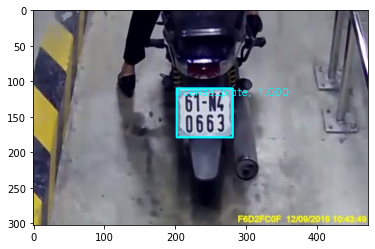

In [46]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess
from torchvision.ops.boxes import batched_nms
transform = Data_Transform(False)
index = 2105
compound_coef = 0
force_input_size = None  # set None to use default size
img_path = img_list[index]
anno = annotations[index]


img = cv2.imread(img_path)
height, width, _ = img.shape
img = transform(img)
img = torch.from_numpy(img).unsqueeze(0).permute(0, 3, 1, 2).cuda().float()
model = model.cuda().float()
features, regression, classification, anchors = model(img)

ground_truth = np.array([[int(anno[0]*width), int(anno[1]*height), int(anno[2]*width), int(anno[3]*height)]])
print(ground_truth)
regressBoxes = BBoxTransform()
clipBoxes = ClipBoxes()

threshold = 0.5
iou_threshold = 0.5

def postprocess(x, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold):
    transformed_anchors = regressBoxes(anchors, regression)
    transformed_anchors = clipBoxes(transformed_anchors, x)
    scores = torch.max(classification, dim=2, keepdim=True)[0]
    scores_over_thresh = (scores > threshold)[:, :, 0]
    out = []
    for i in range(x.shape[0]):
        if scores_over_thresh[i].sum() == 0:
            out.append({
                'rois': np.array(()),
                'class_ids': np.array(()),
                'scores': np.array(()),
            })
            continue

        classification_per = classification[i, scores_over_thresh[i, :], ...].permute(1, 0)
        transformed_anchors_per = transformed_anchors[i, scores_over_thresh[i, :], ...]
        scores_per = scores[i, scores_over_thresh[i, :], ...]
        scores_, classes_ = classification_per.max(dim=0)
        anchors_nms_idx = batched_nms(transformed_anchors_per, scores_per[:, 0], classes_, iou_threshold=iou_threshold)

        if anchors_nms_idx.shape[0] != 0:
            classes_ = classes_[anchors_nms_idx]
            scores_ = scores_[anchors_nms_idx]
            boxes_ = transformed_anchors_per[anchors_nms_idx, :]

            out.append({
                'rois': boxes_.detach().cpu().numpy(),
                'class_ids': classes_.detach().cpu().numpy(),
                'scores': scores_.detach().cpu().numpy(),
            })
        else:
            out.append({
                'rois': np.array(()),
                'class_ids': np.array(()),
                'scores': np.array(()),
            })

    return out


out = postprocess(img, anchors, regression, classification, regressBoxes, clipBoxes, threshold, iou_threshold)



use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = ["license_plate"]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model.requires_grad_(False)
model.eval()



with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])
        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i][:, :, (2, 1, 0)])
        preds = np.array([[x1, y1, x2, y2]])
        print(preds)
        print(jaccard(torch.from_numpy(ground_truth), torch.from_numpy(preds)))


In [31]:
sum([p.numel() for p in model.parameters()])

3828002